<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/proof/hybrid_model_2024-07-17/hybrid_model_2024_07_17(all_diseases).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import pathlib

In [ ]:
import tensorflow_hub as hub

In [ ]:
import os

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/corn_plant_dataset'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/corn_plant_dataset')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 3852 files belonging to 4 classes.
Using 2697 files for training.
Using 1155 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Common_rust', 'Gray_leaf_spot', 'Northern_Leaf_Blight', 'healthy']

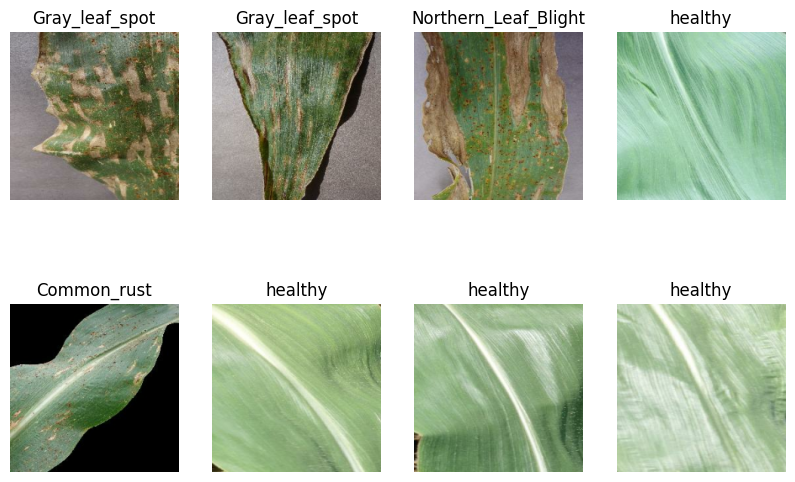

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 37


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 3)
validation_dataset = val_ds.skip(val_batches // 3)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 25
Number of test batches: 12


# ViT model

In [ ]:
vit_url = "https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-s16-fe/1"  # vit-s16-fe


# Custom Layers

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Attention layer

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        attention_map = self.conv(concat)
        return inputs * attention_map

# CNN model

In [ ]:
def create_cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = rescale(inputs)
    x = data_augmentation(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Add Spatial Attention layer here
    x = SpatialAttention()(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Hybrid model 1

In [ ]:
def create_hybrid_model_with_pretrained_vit(input_shape, num_classes, vit_feature_extractor,cnn_model):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Data augmentation and rescaling
    x = data_augmentation(inputs)
    x = rescale(x)

    # Pretrained ViT feature extractor
    vit_features = vit_feature_extractor(x)

    # Custom CNN component
    cnn_model = create_cnn_model(input_shape, num_classes)
    cnn_features = cnn_model(inputs)

    # Concatenate the outputs of ViT and CNN
    combined_features = layers.Concatenate()([vit_features, cnn_features])

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    hybrid_model = models.Model(inputs=inputs, outputs=outputs)
    hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    hybrid_model.summary()
    return hybrid_model

## Train hybrid model 1

In [ ]:
input_shape = (224,224,3)
num_classes = len(class_names)
epochs = 150

In [ ]:
cnn_fe = create_cnn_model(input_shape,num_classes)
vit_fe = hub.KerasLayer(vit_url, trainable=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                             

In [ ]:
num_classes

4

In [ ]:
hybrid_model = create_hybrid_model_with_pretrained_vit(input_shape, num_classes, vit_fe,cnn_fe)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/hybrid_model_2024-07-17/hybrid_models'

In [ ]:
def runExperiment(train_ds, validation_ds, test_ds, input_shape, num_classes, hybrid_model, epochs):

    # Train the model
    history = hybrid_model.fit(
        train_ds,
        validation_data=validation_ds,
        verbose=1,
        epochs=epochs,
        callbacks=[early_stopping],
        batch_size=32
    )

    hybrid_model.save(os.path.join(model_path, f'model_depth_{4}.keras'))

    # Evaluate the model
    test_loss, test_accuracy = hybrid_model.evaluate(test_ds)
    print(f'Test accuracy: {test_accuracy}')

    return history, test_loss, test_accuracy

In [ ]:
history, test_loss, test_accuracy = runExperiment(train_ds, validation_dataset, test_dataset, input_shape, num_classes, hybrid_model, epochs)

Epoch 1/150
85/85 [==============================] - 570s 7s/step - loss: 0.4153 - accuracy: 0.8335 - val_loss: 0.1398 - val_accuracy: 0.9364
Epoch 2/150
85/85 [==============================] - 20s 215ms/step - loss: 0.1987 - accuracy: 0.9166 - val_loss: 0.1148 - val_accuracy: 0.9507
Epoch 3/150
85/85 [==============================] - 20s 229ms/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.1095 - val_accuracy: 0.9507
Epoch 4/150
85/85 [==============================] - 21s 230ms/step - loss: 0.1639 - accuracy: 0.9296 - val_loss: 0.1004 - val_accuracy: 0.9585
Epoch 5/150
85/85 [==============================] - 20s 221ms/step - loss: 0.1465 - accuracy: 0.9429 - val_loss: 0.1000 - val_accuracy: 0.9468
Epoch 6/150
85/85 [==============================] - 21s 233ms/step - loss: 0.1401 - accuracy: 0.9459 - val_loss: 0.1079 - val_accuracy: 0.9507
Epoch 7/150
85/85 [==============================] - 20s 226ms/step - loss: 0.1319 - accuracy: 0.9407 - val_loss: 0.1157 - val_accuracy: 0

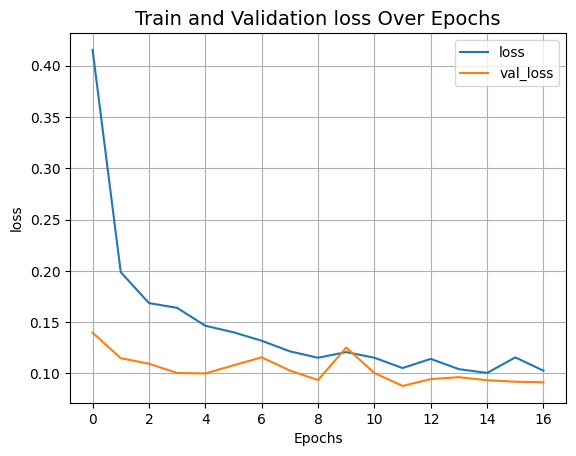

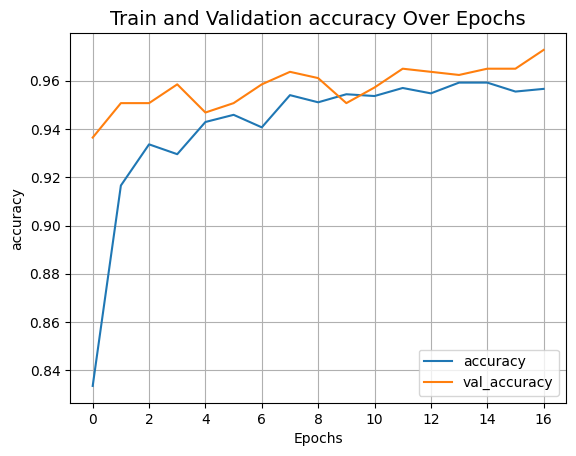

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

# Confusion matrix

In [ ]:
predictions = hybrid_model.predict(test_dataset)
predictions

12/12 [==============================] - 3s 140ms/step


array([[1.01571494e-07, 6.92594722e-06, 1.21384683e-05, 9.99980807e-01],
       [2.64824106e-04, 5.08548439e-01, 4.91120517e-01, 6.62390303e-05],
       [2.56465501e-06, 1.11722502e-05, 5.38393615e-05, 9.99932408e-01],
       ...,
       [2.98298601e-05, 9.80494976e-01, 1.94586534e-02, 1.65923720e-05],
       [5.15004722e-05, 5.22968292e-01, 4.76962954e-01, 1.72758846e-05],
       [2.81859889e-06, 1.18148969e-02, 9.88180399e-01, 1.86517366e-06]],
      dtype=float32)

In [ ]:
y_pred_classes = np.argmax(predictions, axis=1)
y_pred_classes

array([3, 1, 3, 0, 3, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 3, 3, 0, 3, 3, 2, 0,
       2, 0, 3, 0, 3, 2, 2, 2, 2, 3, 0, 2, 3, 0, 1, 2, 3, 3, 3, 3, 2, 1,
       2, 0, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 0, 2, 3, 3, 0, 0, 2, 3, 3, 2,
       2, 0, 2, 0, 3, 1, 2, 2, 0, 1, 3, 3, 2, 2, 0, 2, 3, 2, 0, 2, 0, 0,
       3, 2, 0, 3, 2, 1, 2, 1, 0, 1, 1, 3, 0, 2, 3, 2, 0, 0, 3, 0, 3, 2,
       1, 0, 0, 1, 0, 0, 2, 2, 2, 3, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 3, 2,
       0, 3, 3, 2, 2, 3, 0, 1, 2, 2, 0, 3, 2, 0, 3, 0, 2, 3, 0, 3, 0, 0,
       1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 0, 2, 3, 2, 0, 3, 3, 0, 3, 2,
       2, 0, 0, 2, 3, 2, 0, 0, 3, 0, 2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 0,
       3, 2, 0, 1, 0, 0, 2, 2, 3, 2, 3, 0, 1, 1, 1, 1, 2, 2, 2, 3, 0, 2,
       3, 0, 2, 0, 2, 0, 3, 3, 2, 0, 3, 0, 1, 2, 0, 3, 2, 1, 2, 1, 2, 0,
       0, 3, 3, 1, 3, 0, 2, 2, 3, 3, 2, 0, 3, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       1, 0, 0, 0, 3, 2, 2, 0, 1, 2, 0, 3, 3, 0, 0, 0, 3, 2, 2, 3, 0, 2,
       2, 2, 3, 3, 0, 2, 2, 2, 2, 3, 2, 0, 0, 0, 2,

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([3, 1, 3, 0, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 0, 3, 3, 2, 0,
       2, 0, 3, 0, 3, 2, 2, 2, 2, 3, 0, 2, 3, 0, 2, 2, 3, 3, 3, 3, 2, 1,
       2, 0, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 0, 2, 3, 3, 0, 0, 2, 3, 3, 2,
       2, 0, 2, 0, 3, 1, 2, 1, 0, 1, 3, 3, 2, 2, 0, 2, 3, 2, 0, 2, 0, 0,
       3, 2, 0, 3, 1, 1, 2, 1, 0, 1, 1, 3, 0, 2, 3, 2, 0, 0, 3, 0, 3, 2,
       1, 0, 0, 1, 0, 0, 2, 2, 2, 3, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 3, 2,
       0, 3, 3, 2, 2, 3, 0, 1, 2, 1, 0, 3, 2, 0, 3, 0, 2, 3, 0, 3, 0, 0,
       1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 0, 2, 3, 2, 0, 3, 3, 0, 3, 2,
       2, 0, 0, 2, 3, 2, 0, 0, 3, 0, 1, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 0,
       3, 2, 0, 1, 0, 0, 2, 2, 3, 2, 3, 0, 1, 1, 1, 1, 2, 2, 2, 3, 0, 2,
       3, 0, 1, 0, 2, 0, 3, 3, 2, 0, 3, 0, 1, 2, 0, 3, 2, 1, 2, 1, 2, 0,
       0, 3, 3, 1, 3, 0, 2, 2, 3, 3, 2, 0, 3, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       1, 0, 0, 0, 3, 2, 2, 0, 1, 2, 0, 3, 3, 0, 0, 0, 3, 2, 2, 3, 0, 2,
       2, 2, 3, 3, 0, 2, 2, 2, 2, 3, 2, 0, 0, 0, 2,

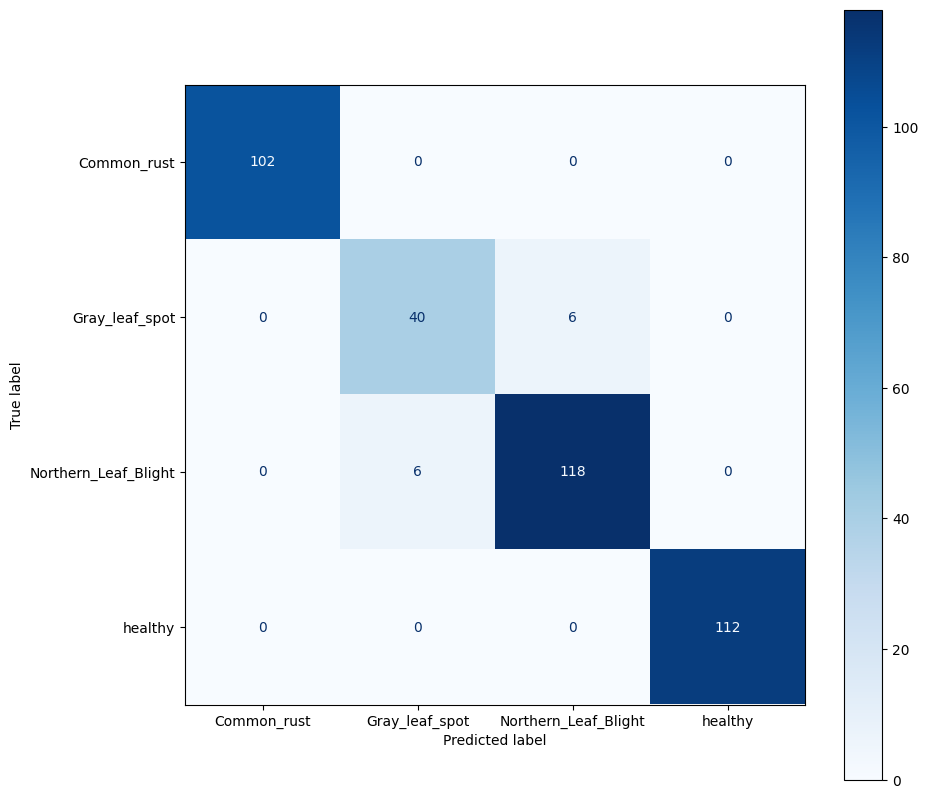

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()